In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import svm
# from sklearn.feature_extraction.text
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import chardet
import re
import os

In [2]:
with open('emails.csv', 'rb') as f:
    result = chardet.detect(f.read())
har = pd.read_csv('emails.csv', encoding=result['encoding'])

In [3]:
har.columns=['text', 'spam']
har['text']=har['text'].apply(lambda text: re.sub(r'[^a-zA-Z\s]','', text))

In [4]:
vectoriser = CountVectorizer(stop_words='english')
vectorised_data = vectoriser.fit_transform(har['text'])
vectorised_data = vectorised_data.toarray()
feat=vectoriser.get_feature_names_out()
print(vectorised_data.shape)
with open('featurename.txt','w') as file:
    for f in feat:
        file.write(f + '\n')
Y= np.where(har['spam']==1, 1, 0)
# print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(vectorised_data, Y, test_size=0.2, random_state=40)
print(Y_train)
#laplace smoothening
a_ones = np.ones_like(X_train[0])
X_train= list(X_train)
X_train.append(a_ones)
X_train.append(a_ones)
Y_train= list(Y_train)
Y_train.append(0)
Y_train.append(1)
a_ones = np.zeros_like(X_train[0])
X_train= list(X_train)
X_train.append(a_ones)
X_train.append(a_ones)
Y_train= list(Y_train)
Y_train.append(0)
Y_train.append(1)
X_train= np.array(X_train)
Y_train=np.array(Y_train)


(5728, 33408)
[0 0 0 ... 0 0 0]


In [5]:
#Naive Bayes algorithm 
bin_mat = np.where(X_train>0,1, 0 )
phi_nb = np.sum(Y_train)/Y_train.size
print(phi_nb)
bin_mat0 = bin_mat[Y_train==0]
bin_mat1 = bin_mat[Y_train==1]
h, w = bin_mat0.shape
p0_nb= np.sum(bin_mat0, axis=0)/h
h, w = bin_mat1.shape
p1_nb= np.sum(bin_mat1, axis=0)/h
print(p1_nb)
print(p0_nb)


0.23528129088530308
[0.00185357 0.00092678 0.00092678 ... 0.00092678 0.00092678 0.00370714]
[0.00655831 0.00142572 0.00057029 ... 0.00028514 0.00085543 0.00028514]


In [6]:
X_test= np.array(X_test)
Y_test=np.array(Y_test)
pre = np.zeros_like(Y_test)
bin_mat = np.where(X_test>0,1, 0 )
h, w = bin_mat.shape
print(h, w)
print(p1_nb)
acc=0
for i in range(h):
    pro_0=np.prod((p0_nb**bin_mat[i])*((1-p0_nb)**(1-bin_mat[i])))
    pro_1=np.prod((p1_nb**bin_mat[i])*((1-p1_nb)**(1-bin_mat[i])))
    if phi_nb*pro_1>(1-phi_nb)*pro_0:
        pre[i]=1
    else:
        pre[i]=0
temp = np.sum(np.abs(Y_test-pre))     
print(temp)  
print((1-(temp/Y_train.shape[0]))*100)

1146 33408
[0.00185357 0.00092678 0.00092678 ... 0.00092678 0.00092678 0.00370714]
56
98.77889228085478


In [7]:
X_test= np.array(X_test)
Y_test=np.array(Y_test)
pre = np.zeros_like(Y_test)
bin_mat = np.where(X_test>0,1, 0 )
h, w = bin_mat.shape
print(h, w)
acc=0
t2_nb= math.log(phi_nb/(1-phi_nb))
t2_nb+=np.sum(np.log((1-p1_nb)/(1-p0_nb)))
t1_nb=np.log((p1_nb*(1-p0_nb))/((p0_nb*(1-p1_nb))), dtype='float64')
for i in range(h):
    if (np.dot(t1_nb, bin_mat[i])+t2_nb)>=0:
        pre[i]=1

temp = np.sum(np.abs(Y_test-pre))     
print(temp)  
print((1-(temp/Y_train.shape[0]))*100)


1146 33408
31
99.32402965547318


In [8]:
#Gaussian Naive's algorithm 
# mean_0= np.mean(X_train[Y_train==0], axis=0)
# mean_1= np.mean(X_train[Y_train==1], axis=0)
# X_0 = X_train[Y_train==0]
# X_1 = X_train[Y_train==1]
# print(X_0)
# X_0 = X_0- mean_0
# X_1 = X_1- mean_1
# # cov = np.matmul(X_0.T, X_0)
# cov1 =  np.matmul(X_1.T, X_1)
# cov = cov + cov1

In [9]:
#logistic regression
#gradient accent algorithm:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def logistic_regression(X, y, stepsize,axisx,axisy_train,axisy_test,  iterations):
    n, d = X.shape
    w= np.zeros(d)
    for i in range(iterations):
        axisx.append(i+1)
        predictions = sigmoid(np.dot(X, w))  #X has the shape nxd and y as nx1
        gradient = np.dot(X.T,(y-predictions))
        w+= stepsize*gradient
        expec= np.matmul(w.T, X_test.T)
        expec= np.where(expec>0.5, 1, 0)
        temp = np.sum(np.abs(Y_test-expec))
        axisy_test.append(temp)   
        expec= np.matmul(w, X_train.T)
        expec= np.where(expec>0.5, 1, 0)
        temp = np.sum(np.abs(Y_train-expec)) 
        axisy_train.append(temp)      
    return w

In [10]:
stepsize= 0.01
iterations =100
print (Y_train.shape)
axisx=[]
axisy_train=[]
axisy_test=[]
weights_logreg = logistic_regression(X_train, Y_train, stepsize,axisx, axisy_train,axisy_test, iterations)
expec= np.matmul(weights_logreg.T, X_test.T)
expec= np.where(expec>0.5, 1, 0)
temp = np.sum(np.abs(Y_test-expec))  
expec= np.matmul(weights_logreg.T, X_train.T)
expec= np.where(expec>0.5, 1, 0)
temp = np.sum(np.abs(Y_train-expec))     
print((1-(temp/Y_train.shape[0]))*100)

(4586,)


/var/folders/rl/3m72t40d3_18r9rdcry1mc180000gn/T/ipykernel_19609/1386023106.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


99.93458351504579


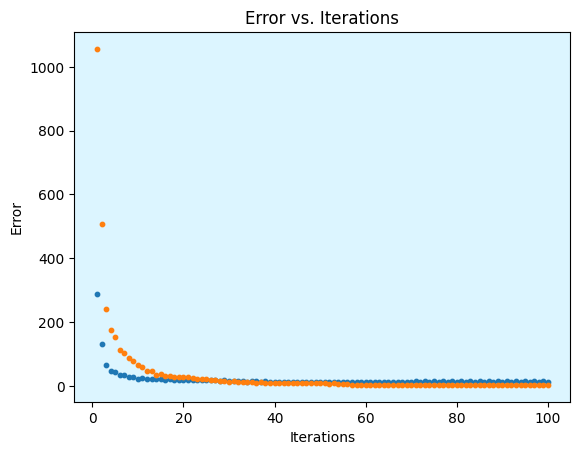

In [11]:
ax = plt.axes()
ax.set_facecolor('#dcf5ff')
ax.scatter(axisx, axisy_test, marker='o', linestyle='-', s = 10)
ax.scatter(axisx, axisy_train, marker='o', linestyle='-', s = 10)
ax.set_xlabel('Iterations')
ax.set_ylabel('Error')
ax.set_title('Error vs. Iterations')
# ax.grid(True)
plt.show()

In [12]:
#perceptron algorithm:
#It expects the linear seperability of algorithms so we have to assume there is a line passing through the origin and run the algorithm 
#we have to convert the y_test and train data set as 1 and -1
y_test = np.where(Y_test==0, -1, 1)
y_train = np.where(Y_train==0, -1, 1)
def perceptron(X_train, y_train, max_iter, axisx, axisy):
    w0= np.zeros(X_train.shape[1])
    y_pre= np.zeros(X_train.shape[1])
    error=1
    for i in range(max_iter):
        axisx.append(i)
        if error!=0:
            y_pre= np.matmul(X_train, w0)
            y_pre = np.where(y_pre>=0, 1, -1 )
            y_pre = y_train- y_pre
            ind = np.argmax(y_pre!=0)
            w0 +=y_train[ind]* X_train[ind].T
            error = np.sum(np.abs(y_pre))
            axisy.append(error/2)
        else: 
            break
    return w0
    
        

In [13]:
axisx=[]
axisy=[]
w_har= perceptron(X_train, y_train, 100, axisx, axisy)
# print(w.shape)
y_pre = np.dot(X_test, w_har)
y_pre = np.where(y_pre>=0, 1, -1)
y_pre = y_pre - y_test
error = np.sum(np.abs(y_pre))
# print(axisx)
print(error/2)
print((1-(error/Y_train.shape[0]))*100)

53.0
97.68861753161798


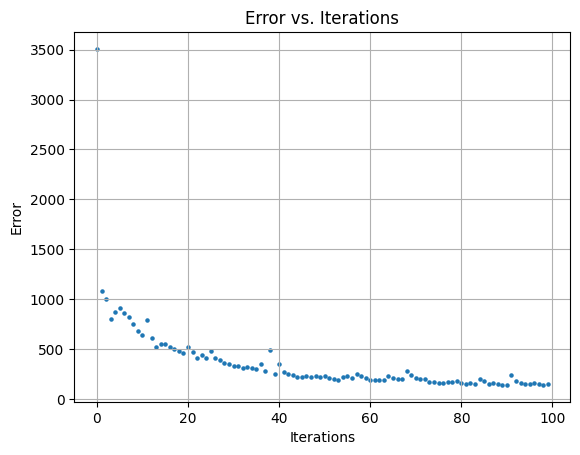

In [14]:
plt.scatter(axisx, axisy, marker='o', linestyle='-', s = 5)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs. Iterations')
plt.grid(True)
plt.show()

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming you have already split your data into training and testing sets
# X_train and y_train are your training data and labels
# X_test and y_test are your testing data and labels

# Create an SVM classifier
svm_classifier = SVC(kernel='linear')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.

# Train the SVM classifier
svm_classifier.fit(X_train, Y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)

print("test_Accuracy using svm:", accuracy*100)            


test_Accuracy using svm: 98.95287958115183


In [16]:
# y_pred = svm_classifier.predict(X_train)
# accuracy = accuracy_score(Y_train, y_pred)
# print("train_Accuracy using svm:", accuracy)

In [17]:
#perceptron with margin:
def perceptron_with_margin(X_train, y_train, max_iter,gamma, axisx, axisy):
    w0= np.zeros(X_train.shape[1])
    y_pre= np.zeros(X_train.shape[1])
    error=1
    for i in range(max_iter):
        axisx.append(i)
        if error!=0:
            y_pre= np.matmul(X_train, w0)
            y_pre = np.where(y_pre>=gamma, 1, -1 )
            y_pre = y_train- y_pre
            ind = np.argmax(y_pre!=0)
            w0 +=y_train[ind]* X_train[ind].T
            error = np.sum(np.abs(y_pre))
            axisy.append(error/2)
        else: 
            break
    return w0

47.0
97.9502834714348


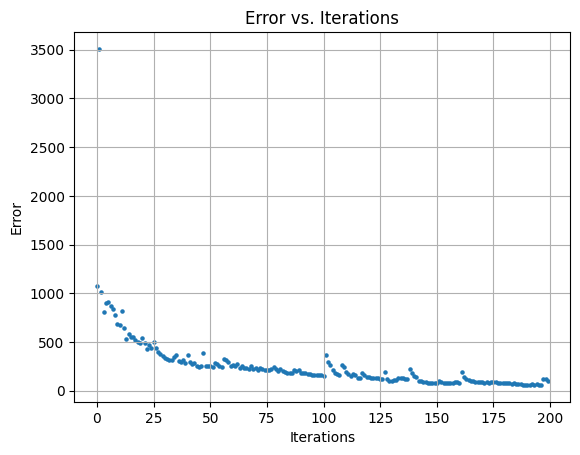

In [18]:
axisx=[]
axisy=[]
w_har1= perceptron_with_margin(X_train, y_train, 200,1,  axisx, axisy)
# print(w.shape)
y_pre = np.dot(X_test, w_har1)
y_pre = np.where(y_pre>=0, 1, -1)
# print(y_pre.shape)
# print(y_train.shape)
y_pre = y_pre - y_test
error = np.sum(np.abs(y_pre))
# print(axisx)
print(error/2)
print((1-(error/Y_train.shape[0]))*100)
plt.scatter(axisx, axisy, marker='o', linestyle='-', s=5)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs. Iterations')
plt.grid(True)
plt.show()